https://medium.com/nerd-for-tech/policy-gradients-reinforce-with-baseline-6c871a3a068

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [25]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 500

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.outpu_layer = nn.Linear(128, action_space)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.outpu_layer(x) # logits
        action_probs = F.softmax(actions, dim=1) # probablity distribution of action
        return action_probs

#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)
        return state_value

#Selects an action given current state
def select_action(network, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)  #convert state to float tensor
    action_probs = network.forward(state)
    state = state.detach()

    # sample action using prob distribution
    m = Categorical(action_probs)
    action = m.sample()

    return action.item(), m.log_prob(action)

def process_rewards(rewards):
    ''' Converts our rewards history into cumulative discounted rewards
    Args:
    - rewards (Array): array of rewards

    Returns:
    - G (Array): array of cumulative discounted rewards
    '''
    G = []
    total_r = 0

    for r in reversed(rewards):
        total_r = r + total_r * DISCOUNT_FACTOR
        G.insert(0, total_r)

    #normalize
    G = torch.tensor(G).to(DEVICE)
    G = (G - G.mean())/G.std()

    return G

def train_policy(deltas, log_probs, optimizer):
    ''' Update policy parameters
    Args:
    - deltas (Array): difference between predicted stateval and actual stateval (Gt)
    - log_probs (Array): trajectory of log probabilities of action taken
    - optimizer (Pytorch optimizer): optimizer to update policy network parameters
    '''
    policy_loss = []

    #calculate loss to be backpropagated
    for d, lp in zip(deltas, log_probs):
        policy_loss.append(-d * lp)

    #Backpropagation
    optimizer.zero_grad()
    sum(policy_loss).backward()
    optimizer.step()

def train_value(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): trajectory of cumulative discounted rewards
    - state_vals (Array): trajectory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''
    val_loss = F.mse_loss(state_vals, G)

    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()

In [27]:
env = gym.make('CartPole-v1')

policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)

policy_optimizer = optim.Adam(policy_network.parameters(), lr=1e-2)
stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=1e-2)

In [28]:
# train
scores = []

recent_scores = deque(maxlen=100)

for episode in tqdm_notebook(range(NUM_EPISODES)):
    state = env.reset()
    trajectory = []
    score = 0

    #generate episode
    for step in range(MAX_STEPS):
        action, lp = select_action(policy_network, state)
        new_state, reward, done, _ = env.step(action)
        score += reward

        trajectory.append([state, action, reward, lp])

        if done:
            break

        state = new_state

    #append score for each episode
    scores.append(score)
    recent_scores.append(score)

    #check if agent finished training by comparing the avg score of 100 epsiode
    if len(recent_scores) == 100:
        average = sum(recent_scores)/len(recent_scores)
        if average >= SOLVED_SCORE:
            break

    #get items from trajectory
    states = [step[0] for step in trajectory]
    actions = [step[1] for step in trajectory]
    rewards = [step[2] for step in trajectory]
    lps = [step[3] for step in trajectory]

    #get discounted rewards
    G = process_rewards(rewards)

    #train
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_vals.append(stateval_network(state)) # predicting state_vals

    state_vals = torch.stack(state_vals).squeeze()

    train_value(G, state_vals, stateval_optimizer) # train the state_vals for next time

    deltas = [gt - val for gt, val in zip(G, state_vals)]
    deltas = torch.tensor(deltas).to(DEVICE)

    train_policy(deltas, lps, policy_optimizer)

env.close()

d:\RL\policy-gradient\.venv\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1000 [00:00<?, ?it/s]

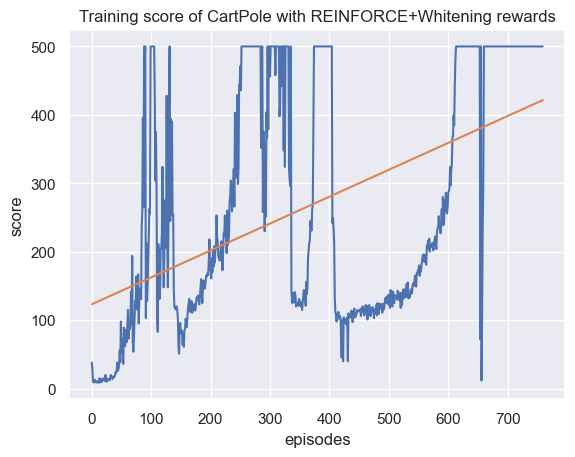

In [29]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with REINFORCE+Whitening rewards')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [31]:
state = env.reset()
done = False

while not done:
    action, _ = select_action(policy_network, state)
    state, reward, done, _ = env.step(action)
    env.render()

env.close()